In [9]:
import gzip
import pickle
import glob
import pandas as pd
import numpy as np
import os
from metient.util import eval_util as eutil
from metient.util.globals import *
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import itertools

REPO_DIR = os.path.join(os.getcwd(), "../../")

METRICS = ["Migration", "Comigration", "Seeding site"]
DATASET_NAMES = [ "HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_vi_orchard_eta", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/orchard_eta_solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/tracerx_trees_largebs_08122024/calibrate",)]

num_bootstrap_samples = 100

num_mets = []
dataset_to_pickle_files = {dataset:[] for dataset in DATASET_NAMES}
for dataset_name, calibrate_dir in zip(DATASET_NAMES, CALIBRATE_DIRS):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    print(calibrate_dir)
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            num_sites = len(pkl[OUT_SITES_KEY])
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            # Only patients with multiple pareto optimal trees should be included, 
            # since they are the only ones who impact the calibration metrics
            if len(loss_dicts) == 1:
                continue
            dataset_to_pickle_files[dataset_name].append((fn, num_sites))
            num_mets.append(num_sites)

def convert_thetas_to_alt_metrics(thetas):
    wtot = thetas[0] + thetas[1]
    delta = thetas[1]/wtot
    return wtot, delta, thetas[2]
    
sizes = {k:len(v) for k,v in dataset_to_pickle_files.items()}
sizes


/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/mcpherson_ovarian_2016/metient_outputs/solve_polys/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_vi_orchard_eta/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/gundem_neuroblastoma_2023/metient_outputs/orchard_eta_solve_polys/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/tracerx_nsclc/metient_outputs/tracerx_trees_largebs_08122024/calibrate


{'HGSOC': 8, 'Melanoma': 6, 'HR-NB': 14, 'NSCLC': 57}

### How consistent are the thetas when calibrated on random samples within the same cancer type cohort?

In [2]:
data = []


# Bootstrap sampling
for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    for dataset in dataset_to_pickle_files:
        matching_files = [x[0] for x in dataset_to_pickle_files[dataset]]
        print(len(matching_files))
        if len(matching_files) == 0:
            continue
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
        pt_weights = [1.0 for _ in range(len(bootstrap_sample))]
        thetas = eutil.get_max_cross_ent_thetas(bootstrap_sample, pt_weights)
        for midx, metric in enumerate(METRICS):
            data.append([dataset, metric, thetas[midx]])

thetas_split_on_same_cohort = pd.DataFrame(data, columns=["dataset", "Parsimony metric", "Fit theta"])
thetas_split_on_same_cohort.to_csv('thetas_split_on_same_cohort.csv') 
thetas_split_on_same_cohort


**** RUN 1 ***
8
Calibrating to 5 patients
Optimized thetas: tensor([0.5274, 0.1802, 0.2923], grad_fn=<DivBackward0>)
6
14
Calibrating to 6 patients
Optimized thetas: tensor([0.2127, 0.4382, 0.3491], grad_fn=<DivBackward0>)
57
Calibrating to 25 patients
Optimized thetas: tensor([0.3632, 0.4024, 0.2344], grad_fn=<DivBackward0>)

**** RUN 2 ***
8
Calibrating to 2 patients
Optimized thetas: tensor([0.5309, 0.1729, 0.2963], grad_fn=<DivBackward0>)
6
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 11 patients
Optimized thetas: tensor([0.5093, 0.2634, 0.2273], grad_fn=<DivBackward0>)
57
Calibrating to 21 patients
Optimized thetas: tensor([0.4138, 0.3295, 0.2567], grad_fn=<DivBackward0>)

**** RUN 3 ***
8
Calibrating to 2 patients
Early stopping after 907 epochs.
Optimized thetas: tensor([0.4167, 0.3269, 0.2564], grad_fn=<DivBackward0>)
6
Calibrating to 3 patients
Early stopping after 51 ep

Early stopping after 718 epochs.
Optimized thetas: tensor([0.5636, 0.1759, 0.2605], grad_fn=<DivBackward0>)
6
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 8 patients
Optimized thetas: tensor([0.4176, 0.2867, 0.2957], grad_fn=<DivBackward0>)
57
Calibrating to 23 patients
Optimized thetas: tensor([0.4318, 0.3554, 0.2127], grad_fn=<DivBackward0>)

**** RUN 19 ***
8
Calibrating to 6 patients
Optimized thetas: tensor([0.5480, 0.1725, 0.2795], grad_fn=<DivBackward0>)
6
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 7 patients
Optimized thetas: tensor([0.2455, 0.3973, 0.3572], grad_fn=<DivBackward0>)
57
Calibrating to 20 patients
Optimized thetas: tensor([0.3187, 0.4120, 0.2693], grad_fn=<DivBackward0>)

**** RUN 20 ***
8
Calibrating to 3 patients
Optimized thetas: tensor([0.5420, 0.177

Optimized thetas: tensor([0.5578, 0.1788, 0.2634], grad_fn=<DivBackward0>)
6
Calibrating to 2 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 8 patients
Optimized thetas: tensor([0.4982, 0.2754, 0.2264], grad_fn=<DivBackward0>)
57
Calibrating to 21 patients
Optimized thetas: tensor([0.4030, 0.3328, 0.2642], grad_fn=<DivBackward0>)

**** RUN 36 ***
8
Calibrating to 6 patients
Optimized thetas: tensor([0.5442, 0.1826, 0.2732], grad_fn=<DivBackward0>)
6
Calibrating to 2 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 8 patients
Optimized thetas: tensor([0.3203, 0.3575, 0.3222], grad_fn=<DivBackward0>)
57
Calibrating to 19 patients
Optimized thetas: tensor([0.3876, 0.3585, 0.2539], grad_fn=<DivBackward0>)

**** RUN 37 ***
8
Calibrating to 2 patients
Early stopping after 828 epochs.
Optimized thetas: tensor([0.4853, 0.267

Optimized thetas: tensor([0.5429, 0.1711, 0.2860], grad_fn=<DivBackward0>)
6
Calibrating to 3 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 8 patients
Optimized thetas: tensor([0.5404, 0.2580, 0.2016], grad_fn=<DivBackward0>)
57
Calibrating to 25 patients
Optimized thetas: tensor([0.4901, 0.3147, 0.1952], grad_fn=<DivBackward0>)

**** RUN 53 ***
8
Calibrating to 3 patients
Optimized thetas: tensor([0.5429, 0.1711, 0.2860], grad_fn=<DivBackward0>)
6
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 9 patients
Optimized thetas: tensor([0.4824, 0.2578, 0.2598], grad_fn=<DivBackward0>)
57
Calibrating to 22 patients
Optimized thetas: tensor([0.3639, 0.3476, 0.2885], grad_fn=<DivBackward0>)

**** RUN 54 ***
8
Calibrating to 2 patients
Optimized thetas: tensor([0.5459, 0.1707, 0.2835], grad_fn=<DivBackward0

Optimized thetas: tensor([0.5463, 0.2336, 0.2201], grad_fn=<DivBackward0>)
57
Calibrating to 16 patients
Optimized thetas: tensor([0.3661, 0.3616, 0.2723], grad_fn=<DivBackward0>)

**** RUN 70 ***
8
Calibrating to 4 patients
Early stopping after 916 epochs.
Optimized thetas: tensor([0.4059, 0.3284, 0.2657], grad_fn=<DivBackward0>)
6
14
Calibrating to 7 patients
Optimized thetas: tensor([0.4792, 0.2838, 0.2370], grad_fn=<DivBackward0>)
57
Calibrating to 20 patients
Optimized thetas: tensor([0.4609, 0.3298, 0.2093], grad_fn=<DivBackward0>)

**** RUN 71 ***
8
Calibrating to 3 patients
Optimized thetas: tensor([0.4742, 0.2715, 0.2543], grad_fn=<DivBackward0>)
6
14
Calibrating to 12 patients
Optimized thetas: tensor([0.4874, 0.2408, 0.2718], grad_fn=<DivBackward0>)
57
Calibrating to 24 patients
Optimized thetas: tensor([0.3310, 0.3756, 0.2934], grad_fn=<DivBackward0>)

**** RUN 72 ***
8
Calibrating to 1 patients
Early stopping after 271 epochs.
Optimized thetas: tensor([0.5653, 0.1755, 0.25

Optimized thetas: tensor([0.4228, 0.3083, 0.2688], grad_fn=<DivBackward0>)
57
Calibrating to 20 patients
Optimized thetas: tensor([0.4701, 0.3003, 0.2296], grad_fn=<DivBackward0>)

**** RUN 87 ***
8
Calibrating to 5 patients
Early stopping after 644 epochs.
Optimized thetas: tensor([0.4897, 0.2551, 0.2551], grad_fn=<DivBackward0>)
6
14
Calibrating to 5 patients
Optimized thetas: tensor([0.2217, 0.4556, 0.3228], grad_fn=<DivBackward0>)
57
Calibrating to 22 patients
Optimized thetas: tensor([0.3904, 0.3281, 0.2815], grad_fn=<DivBackward0>)

**** RUN 88 ***
8
Calibrating to 1 patients
Early stopping after 271 epochs.
Optimized thetas: tensor([0.5653, 0.1755, 0.2592], grad_fn=<DivBackward0>)
6
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
14
Calibrating to 7 patients
Optimized thetas: tensor([0.5983, 0.1896, 0.2121], grad_fn=<DivBackward0>)
57
Calibrating to 17 patients
Optimized thetas: tensor([0.5346, 

,dataset,Parsimony metric,Fit theta
0,HGSOC,Migration,0.527
1,HGSOC,Comigration,0.180
2,HGSOC,Seeding site,0.292
3,Melanoma,Migration,0.460
4,Melanoma,Comigration,0.290
...,...,...,...
1195,HR-NB,Comigration,0.233
1196,HR-NB,Seeding site,0.272
1197,NSCLC,Migration,0.414
1198,NSCLC,Comigration,0.354


### How consistent are thetas when calibrating on random samples amongst all cancer type cohorts?

In [3]:
data = []
dataset_sizes = []
all_matching_files = []
for dataset in dataset_to_pickle_files:
    files = dataset_to_pickle_files[dataset]
    dataset_sizes.append(len(files))
    all_matching_files.extend(files)
print(dataset_sizes, len(all_matching_files))

for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    matching_files = [x[0] for x in all_matching_files]
    if len(matching_files) == 0:
        continue
    # Create a bootstrap sample by sampling with replacement
    bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
    pt_weights = [1.0 for _ in range(len(bootstrap_sample))]
    thetas = eutil.get_max_cross_ent_thetas(bootstrap_sample, pt_weights)
    for midx, metric in enumerate(METRICS):
        data.append([metric, thetas[midx]])

thetas_split_on_random_cohort = pd.DataFrame(data, columns=["Parsimony metric", "Fit theta"])
thetas_split_on_random_cohort.to_csv('thetas_split_on_random_cohort.csv') 

thetas_split_on_random_cohort

[8, 6, 14, 57] 85

**** RUN 1 ***
Calibrating to 35 patients
Optimized thetas: tensor([0.4197, 0.3405, 0.2397], grad_fn=<DivBackward0>)

**** RUN 2 ***
Calibrating to 30 patients
Optimized thetas: tensor([0.4377, 0.3286, 0.2337], grad_fn=<DivBackward0>)

**** RUN 3 ***
Calibrating to 30 patients
Optimized thetas: tensor([0.4679, 0.2956, 0.2365], grad_fn=<DivBackward0>)

**** RUN 4 ***
Calibrating to 27 patients
Optimized thetas: tensor([0.4960, 0.2531, 0.2509], grad_fn=<DivBackward0>)

**** RUN 5 ***
Calibrating to 34 patients
Optimized thetas: tensor([0.4744, 0.3252, 0.2003], grad_fn=<DivBackward0>)

**** RUN 6 ***
Calibrating to 36 patients
Optimized thetas: tensor([0.4135, 0.2973, 0.2892], grad_fn=<DivBackward0>)

**** RUN 7 ***
Calibrating to 39 patients
Optimized thetas: tensor([0.4786, 0.3029, 0.2185], grad_fn=<DivBackward0>)

**** RUN 8 ***
Calibrating to 29 patients
Optimized thetas: tensor([0.4591, 0.3183, 0.2225], grad_fn=<DivBackward0>)

**** RUN 9 ***
Calibrating to 41 pati

Calibrating to 33 patients
Optimized thetas: tensor([0.5435, 0.2612, 0.1953], grad_fn=<DivBackward0>)

**** RUN 71 ***
Calibrating to 35 patients
Optimized thetas: tensor([0.5079, 0.2590, 0.2331], grad_fn=<DivBackward0>)

**** RUN 72 ***
Calibrating to 30 patients
Optimized thetas: tensor([0.5843, 0.2207, 0.1950], grad_fn=<DivBackward0>)

**** RUN 73 ***
Calibrating to 41 patients
Optimized thetas: tensor([0.5126, 0.2795, 0.2079], grad_fn=<DivBackward0>)

**** RUN 74 ***
Calibrating to 33 patients
Optimized thetas: tensor([0.4995, 0.2137, 0.2868], grad_fn=<DivBackward0>)

**** RUN 75 ***
Calibrating to 33 patients
Optimized thetas: tensor([0.5740, 0.2360, 0.1900], grad_fn=<DivBackward0>)

**** RUN 76 ***
Calibrating to 31 patients
Optimized thetas: tensor([0.4216, 0.3005, 0.2779], grad_fn=<DivBackward0>)

**** RUN 77 ***
Calibrating to 36 patients
Optimized thetas: tensor([0.5483, 0.2178, 0.2339], grad_fn=<DivBackward0>)

**** RUN 78 ***
Calibrating to 32 patients
Optimized thetas: ten

,Parsimony metric,Fit theta
0,Migration,0.420
1,Comigration,0.341
2,Seeding site,0.240
3,Migration,0.438
4,Comigration,0.329
...,...,...
295,Comigration,0.254
296,Seeding site,0.216
297,Migration,0.523
298,Comigration,0.238


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=5.464e-96 stat=4.056e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=3.379e-15 stat=-9.100e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=5.190e-82 stat=4.936e+01


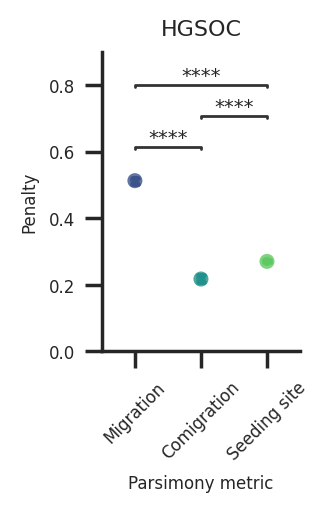

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=2.258e-14 stat=8.667e+00
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=4.210e-03 stat=2.907e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=2.496e-17 stat=9.454e+00


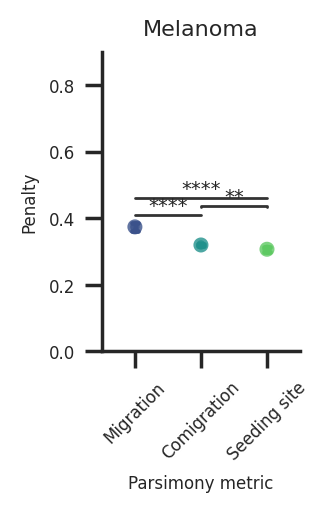

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=2.750e-27 stat=1.327e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=8.504e-04 stat=3.388e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=1.704e-33 stat=1.561e+01


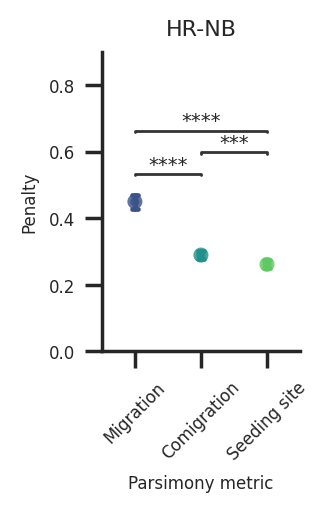

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=3.387e-27 stat=1.325e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=4.836e-41 stat=1.735e+01
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=1.991e-59 stat=2.502e+01


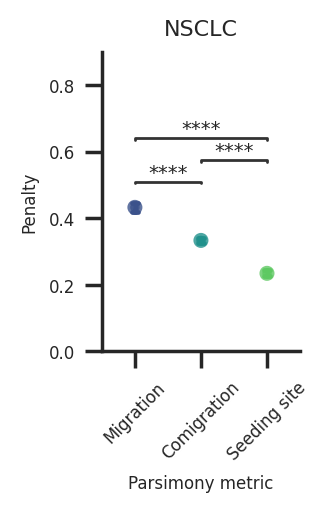

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=8.135e-62 stat=2.556e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=8.180e-12 stat=7.305e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=3.436e-72 stat=3.351e+01


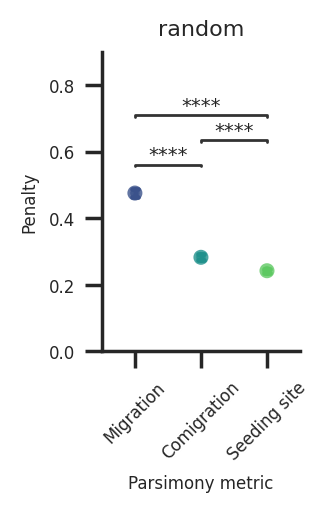

In [10]:
# Load data
thetas_split_on_same_cohort = pd.read_csv('thetas_split_on_same_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 
thetas_split_on_random_cohort = pd.read_csv('thetas_split_on_random_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 

colors = sns.color_palette("flare")[2:]

def point_plot(df, color, name, with_stats):
   
    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, })

    fig = plt.figure(figsize=(2, 2.5), dpi=200)
    snsfig = sns.pointplot(data=df, x='Parsimony metric', y='Fit theta', markersize=0.5, errwidth=1.7,capsize=0.1, 
                           dodge=True, markers='.', errorbar='sd', palette='viridis')

#     snsfig = sns.violinplot(x='Parsimony metric', y='Fit theta', data=df, 
#                          linewidth=0.7, color=color, alpha=0.5, inner=None)
    
    if with_stats:
        add_stat_annotation(snsfig, data=df, x='Parsimony metric', y="Fit theta",
                            box_pairs=itertools.combinations(METRICS, 2),
                            line_offset=0.2,test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.1, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    if with_stats:
        plt.ylim(0, 0.9) 
    else:
        plt.ylim(0, 0.7)
    plt.ylabel("Penalty")
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(name.split(" "))
    plt.setp(snsfig.collections, alpha=0.8)
    plt.tight_layout(pad=1.8) 
    plt.xticks(rotation=45)  
    plt.savefig(f"../output_plots/{saved_name}_theta_distribution.png", dpi=500)
    plt.title(name, fontsize=8)
    plt.show()
    plt.close()

with_stats = True
for i,dataset in enumerate(dataset_to_pickle_files):
    subset = thetas_split_on_same_cohort[thetas_split_on_same_cohort['dataset']==dataset]
    point_plot(subset, colors[i], dataset, with_stats)

point_plot(thetas_split_on_random_cohort, 'lightseagreen', 'random', with_stats)


### Make one plot per metric with datasets side by side 

    Parsimony metric  Fit theta   dataset
0          Migration      0.420  Combined
1        Comigration      0.341  Combined
2       Seeding site      0.240  Combined
3          Migration      0.438  Combined
4        Comigration      0.329  Combined
..               ...        ...       ...
295      Comigration      0.254  Combined
296     Seeding site      0.216  Combined
297        Migration      0.523  Combined
298      Comigration      0.238  Combined
299     Seeding site      0.239  Combined

[300 rows x 3 columns]
       dataset Parsimony metric  Fit theta
0        HGSOC        Migration      0.527
1        HGSOC      Comigration      0.180
2        HGSOC     Seeding site      0.292
3     Melanoma        Migration      0.460
4     Melanoma      Comigration      0.290
...        ...              ...        ...
1195     HR-NB      Comigration      0.233
1196     HR-NB     Seeding site      0.272
1197     NSCLC        Migration      0.414
1198     NSCLC      Comigration      0.354

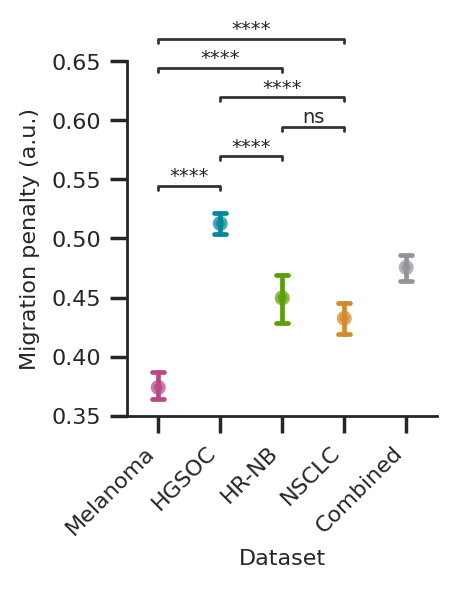

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=1.266e-34 stat=1.716e+01
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=4.079e-16 stat=-8.880e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=1.486e-09 stat=-6.408e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.470e-39 stat=-1.742e+01
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=3.057e-06 stat=4.893e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.122e-03 stat=-3.320e+00


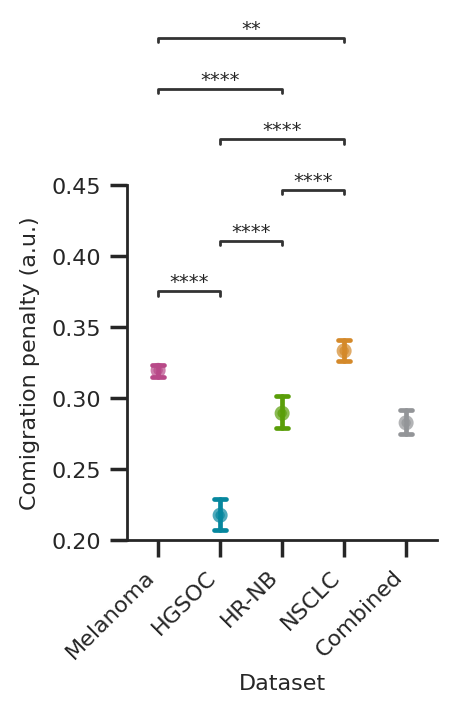

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=1.369e-14 stat=8.687e+00
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=1.418e-01 stat=1.480e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=2.902e-04 stat=3.694e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=5.116e-12 stat=7.644e+00
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=8.346e-10 stat=6.497e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=5.044e-26 stat=1.227e+01


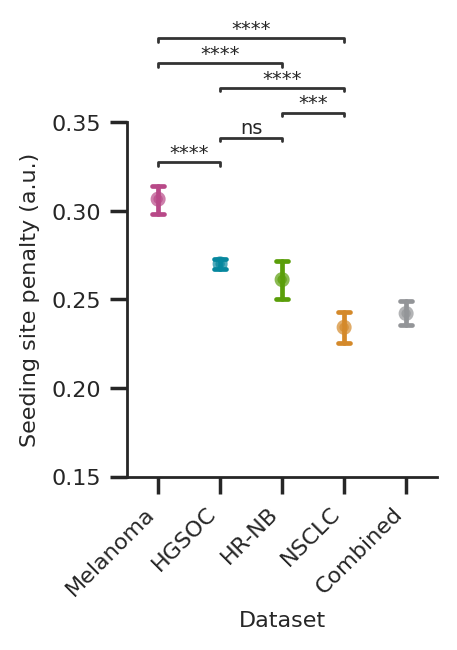

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=3.006e-44 stat=-1.870e+01
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=5.373e-13 stat=7.810e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=1.833e-03 stat=3.171e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=2.878e-34 stat=1.503e+01
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=2.323e-07 stat=-5.431e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.258e-03 stat=-3.273e+00


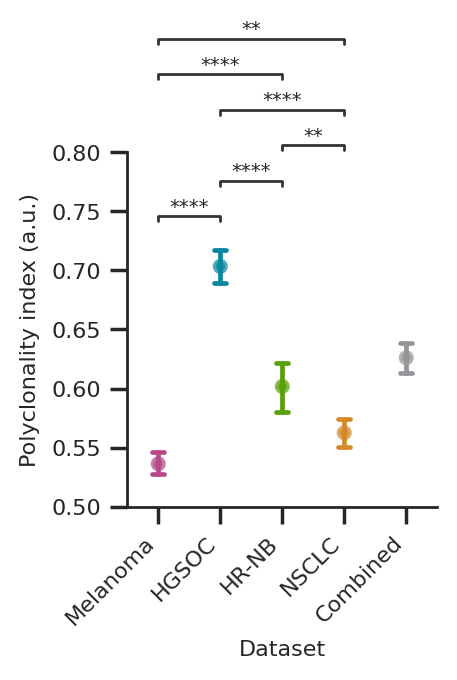

In [24]:
from matplotlib.colors import to_rgb
from statannot import add_stat_annotation
dataset_colors = ["#b84988","#06879e","#5a9e09","#d4892a", "#939598"]

dataset_order = ["Melanoma", "HGSOC", "HR-NB", "NSCLC", "Combined"]
def plot_all_metrics(df, metric, with_stats, ylim, shape=(2,2), colors=None):

    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8,  "axes.linewidth":1.0, })
    subset = df[df['Parsimony metric']==metric]
    if with_stats:
        shape = (shape[0], shape[1]+0.3)
    fig = plt.figure(figsize=(shape[0], shape[1]), dpi=200)

    snsfig = sns.pointplot(data=subset, x='dataset', y='Fit theta', s=5, errwidth=1.7, order=dataset_order,
                           dodge=True, markers='.', errorbar='se', palette=dataset_colors, capsize=0.2)

#     snsfig = sns.violinplot(x='dataset', y='Fit theta', data=subset, palette=colors,
#                          linewidth=0.7, alpha=0.5, inner=None )

    groups = list(subset['dataset'].unique())
    
    # Plot the medians
#     medians = [np.median(subset[subset['dataset']==dataset]['Fit theta']) for dataset in set(groups)]
#     plt.setp(snsfig.collections, alpha=.3)
#     plt.scatter(x=range(len(medians)),y=medians,c="k",s=5.0, )
    
    if with_stats:
        if "Combined" in groups: groups.remove("Combined")

        line_offset = 0.17 if metric == 'Comigration' else 0.07
        add_stat_annotation(snsfig, data=subset, x='dataset', y="Fit theta",
                            box_pairs=itertools.combinations(groups, 2),order=dataset_order, line_offset=line_offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.05, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
        plt.ylim(ylim[0], ylim[1]) 
    else:
        plt.ylim(ylim[0], ylim[1]) 
            
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.xlabel("Dataset", fontsize=8)
    ylabel = f"{metric} penalty" if "index" not in metric else metric
    plt.ylabel(f"{ylabel} (a.u.)", fontsize=8)
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(metric.split(" "))
    plt.setp(snsfig.collections, alpha=0.7)
    #plt.tight_layout() 
    plt.savefig(f"../output_plots/{saved_name}_theta_distribution_stat.png", dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()
    
thetas_split_on_random_cohort['dataset'] = "Combined"
print(thetas_split_on_random_cohort)
print(thetas_split_on_same_cohort)
combined_df = pd.concat([thetas_split_on_same_cohort, thetas_split_on_random_cohort], axis=0)
combined_df = combined_df[combined_df['dataset']!='Breast Cancer'].reset_index(drop=True)

# This is to plot the alternative metrics (Effective migration #, polyclonality index)
import math
group_size = 3
tolerance = 1e-4
rows_to_add = []
for _, group in combined_df.groupby(combined_df.index // group_size):
    assert(math.isclose(group['Fit theta'].sum(),1.0, rel_tol=tolerance, abs_tol=tolerance))
    dataset = group['dataset'].unique().item()

    mig = float(group[group['Parsimony metric']=="Migration"]["Fit theta"].item())
    comig = float(group[group['Parsimony metric']=="Comigration"]["Fit theta"].item())
    ss = float(group[group['Parsimony metric']=="Seeding site"]["Fit theta"].item())
    rows_to_add.append([dataset,  "Migration # index", 1-(mig)])
    rows_to_add.append([dataset,  "Polyclonality index", 1-(comig/(mig+comig))])
    rows_to_add.append([dataset,  "Comigration # index", 1-(comig)])
    rows_to_add.append([dataset,  "Seeding site index", 1-ss])

combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add, columns=combined_df.columns)], axis=0)

with_stats = True
plot_all_metrics(combined_df, 'Migration', with_stats, (0.35,0.65))
plot_all_metrics(combined_df, 'Comigration', with_stats,(0.2,0.45))
plot_all_metrics(combined_df, "Seeding site", with_stats, (0.15,0.35))
plot_all_metrics(combined_df, 'Polyclonality index', with_stats, (0.5,0.8))



### How concordant is the top solution when using the bootstrapped weights?

In [11]:
import torch
data = []

for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):
    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            # For each patient, how would their Pareto optimal trees get reordered
            # with different bootstrapped weights?
            
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            pars_metrics = []
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            dataset_thetas = list(thetas_split_on_same_cohort[thetas_split_on_same_cohort['dataset']==dataset]['Fit theta'])
            for i in range(0, len(dataset_thetas), 3):
                one_samp_thetas = dataset_thetas[i:i+3]
                
                
                best_soln_loss, best_soln_idx = float("inf"), -1
                for x,pars in enumerate(pars_metrics):
                    loss = one_samp_thetas[0]*pars[0]+one_samp_thetas[1]*pars[1] + one_samp_thetas[2]*pars[2]
                    if loss < best_soln_loss:
                        best_soln_idx = x
                        best_soln_loss = loss
                
                data.append([dataset, pid, best_soln_idx])

consistency_df = pd.DataFrame(data, columns=['dataset', 'pid', 'best_soln_idx'])
consistency_df
            

HGSOC 13
Melanoma 7
HR-NB 30
NSCLC 128


,dataset,pid,best_soln_idx
0,HGSOC,7,0
1,HGSOC,7,0
2,HGSOC,7,0
3,HGSOC,7,0
4,HGSOC,7,0
...,...,...,...
17795,NSCLC,CRUK0022,0
17796,NSCLC,CRUK0022,0
17797,NSCLC,CRUK0022,0
17798,NSCLC,CRUK0022,0


In [12]:
import statistics

dataset_to_avg_concurrency = {d:[] for d in consistency_df['dataset'].unique()}
overall_avg_concurrency = []
for pid in consistency_df['pid'].unique():
    best_solutions = list(consistency_df[consistency_df['pid']==pid]['best_soln_idx'])
    mode = statistics.mode(best_solutions)
    # What percent of the boostrapped weights returns the same mode
    mode_count = best_solutions.count(mode)
    percent_mode = (mode_count / len(best_solutions)) * 100
    dataset = consistency_df[consistency_df['pid']==pid]['dataset'].unique().item()
    dataset_to_avg_concurrency[dataset].append(percent_mode)
    overall_avg_concurrency.append(percent_mode)
    
dataset_to_avg_concurrency = {k:sum(v)/len(v) for k,v in dataset_to_avg_concurrency.items()}
print(dataset_to_avg_concurrency)
print(sum(overall_avg_concurrency)/len(overall_avg_concurrency))

{'HGSOC': 97.28571428571429, 'Melanoma': 95.42857142857143, 'HR-NB': 95.74074074074075, 'NSCLC': 99.15079365079364}
98.36526946107784


In [13]:
means = thetas_split_on_same_cohort.groupby(['dataset', 'Parsimony metric'])['Fit theta'].mean().reset_index()

print(means)
print(sizes)
tot_patients = sum(list(sizes.values()))
print("tot_patients", tot_patients)
weighted_avg_mig_theta, weighted_avg_comig_theta, weighted_avg_ss_theta = 0.0,0.0,0.0
for dataset in sizes:
    avg_mig_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Migration')]['Fit theta'].item())
    avg_comig_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Comigration')]['Fit theta'].item())
    avg_ss_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Seeding site')]['Fit theta'].item())
    weighted_avg_mig_theta += sizes[dataset]*avg_mig_theta
    weighted_avg_comig_theta += sizes[dataset]*avg_comig_theta
    weighted_avg_ss_theta += sizes[dataset]*avg_ss_theta
    
weighted_avg_mig_theta = weighted_avg_mig_theta/tot_patients
weighted_avg_comig_theta = weighted_avg_comig_theta/tot_patients
weighted_avg_ss_theta = weighted_avg_ss_theta/tot_patients
print(weighted_avg_mig_theta, weighted_avg_comig_theta, weighted_avg_ss_theta)
    

     dataset Parsimony metric  Fit theta
0      HGSOC      Comigration      0.217
1      HGSOC        Migration      0.513
2      HGSOC     Seeding site      0.270
3      HR-NB      Comigration      0.289
4      HR-NB        Migration      0.450
5      HR-NB     Seeding site      0.261
6   Melanoma      Comigration      0.319
7   Melanoma        Migration      0.374
8   Melanoma     Seeding site      0.307
9      NSCLC      Comigration      0.333
10     NSCLC        Migration      0.433
11     NSCLC     Seeding site      0.234
{'HGSOC': 8, 'Melanoma': 6, 'HR-NB': 14, 'NSCLC': 57}
tot_patients 85
0.438745255372945 0.31405492439606614 0.24719982294300022
